# Sentiment Analysis With Basic Neural Network

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import regex as re
from sklearn.model_selection import train_test_split

# Load IMDB dataset
dataset = tfds.load('imdb_reviews', split='train')
dataframe = tfds.as_dataframe(dataset)

# Decode each text and put into pandas df
df = pd.DataFrame()
regexes = (("<", ""), ("br", "", ), ("/>", ""), ("  ", " "))
reviews = []
for text in dataframe['text']:
    text = text.decode()
    for reg in regexes:
        text = re.sub(reg[0], reg[1], text)
    reviews.append(text)
df['text'] = reviews
df['label'] = dataframe['label']

# Split data into training and validation
train_X, test_X, train_y, test_y = train_test_split(df['text'].values, df['label'].values, test_size=0.2)

2023-06-22 12:54:45.595227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ben/.pyenv/versions/3.10.6/envs/CS556/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-22 12:54:45.595380: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-22 12:54:45.595406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lenovoT14): /proc/driver/nvidia/version does not exist
2023-06-22 12:54:45.596135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow wit

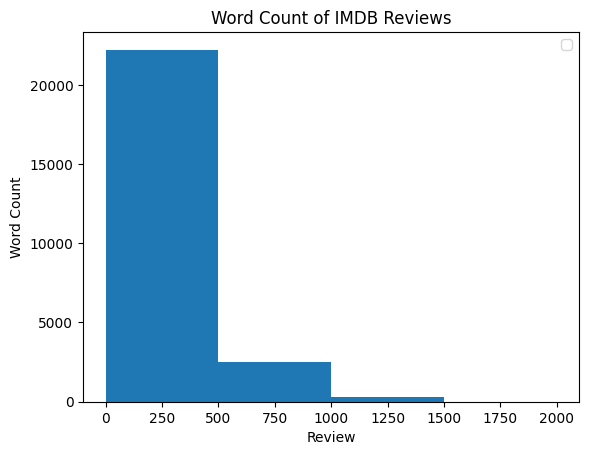

In [8]:
import matplotlib.pyplot as plt
import nltk

# Tokenize each review
tokenized_reviews = []   
for text in df['text']:
    text = nltk.word_tokenize(text)
    tokenized_reviews.append(text)

# Add to new df
df_tok = pd.DataFrame()
df_tok['text'] = tokenized_reviews

# Plot hist of word counts
fig = plt.figure()
ax = fig.add_subplot()
ax.hist([len(text) for text in df_tok['text']], [0, 500, 1000, 1500, 2000])
ax.set_title('Word Count of IMDB Reviews')
ax.set_xlabel('Review')
ax.set_ylabel('Word Count')
ax.legend()

In [10]:
from keras.layers import TextVectorization

# Parameters for vocab size and number of words in a sequence
vocab_size = 10000
sequence_length = 100

# Use TextVectorization to turn strings into vectors of integers
vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size, 
    output_mode='int',
    output_sequence_length=sequence_length)

# Build vocabulary
all_reviews = df['text'].values
vectorize_layer.adapt(all_reviews)

In [70]:
# Build model
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

# Train model
model.fit(train_X, train_y, epochs=30)
history = model.history

Epoch 1/30
625/625 [==============================] - 2s 3ms/step - loss: 0.5536 - accuracy: 0.7453
Epoch 2/30
625/625 [==============================] - 2s 3ms/step - loss: 0.3382 - accuracy: 0.8561
Epoch 3/30
625/625 [==============================] - 2s 3ms/step - loss: 0.2708 - accuracy: 0.8906
Epoch 4/30
625/625 [==============================] - 2s 3ms/step - loss: 0.2289 - accuracy: 0.9111
Epoch 5/30
625/625 [==============================] - 1s 2ms/step - loss: 0.1979 - accuracy: 0.9247
Epoch 6/30
625/625 [==============================] - 1s 2ms/step - loss: 0.1722 - accuracy: 0.9378
Epoch 7/30
625/625 [==============================] - 1s 2ms/step - loss: 0.1496 - accuracy: 0.9480
Epoch 8/30
625/625 [==============================] - 1s 2ms/step - loss: 0.1306 - accuracy: 0.9538
Epoch 9/30
625/625 [==============================] - 1s 2ms/step - loss: 0.1129 - accuracy: 0.9630
Epoch 10/30
625/625 [==============================] - 2s 2ms/step - loss: 0.0971 - accuracy: 0.9699

Text(0, 0.5, 'Loss')

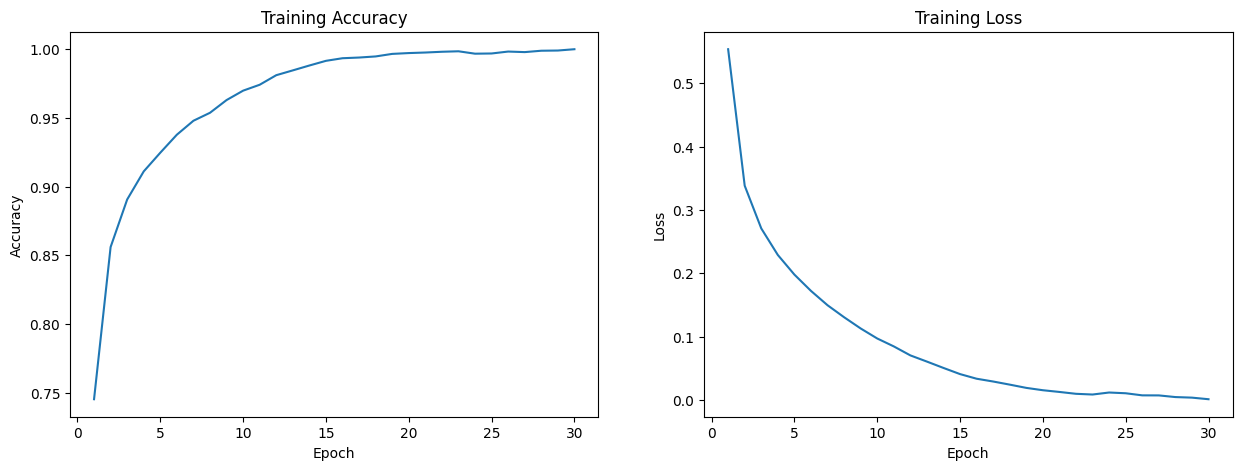

In [71]:
# Graph training accuracy and loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
epochs = [i for i in range(1, len(history.history['loss'])+1)]
axes[0].plot(epochs, history.history['accuracy'], label='traning accuracy')
axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[1].plot(epochs, history.history['loss'], label='loss')
axes[1].set_title('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

In [72]:
# Load buffett letters
letters = []
with open('data/letters.txt', 'r', encoding='utf8') as file:
    for count, line in enumerate(file):

        # Split letter into list of sentences and remove figures
        sents = nltk.sent_tokenize(line)
        for sent in sents:
            if (re.search("\.\.\.\.\.", sent)) is not None:  # Figures indicated by long elipses
                del sents[sents.index(sent)]
            if (re.search("\. \. \. \. ", sent)) is not None:  # 21st letter has spaces inbetween periods
                del sents[sents.index(sent)]
        letters.append(sents)

In [76]:
# Read sp500 data, reverse indices, and start at 1977
sp500 = pd.read_csv('data/sp500.csv')
sp500 = sp500.iloc[::-1]
sp500 = sp500[sp500['year'] >= 1977]
sp500 = sp500.reset_index()

# Load letters and SP500 performance into df
df = pd.DataFrame()
df['Year'] = [i for i in range(1977, 2022)]
df['Letter'] = letters
df['SP500'] = sp500['performance']
df.head()

,Year,Letter,SP500
0,1977,[To the Stockholders of Berkshire Hathaway Inc...,-7.18
1,1978,[To the Shareholders of Berkshire Hathaway Inc...,6.56
2,1979,[To the Shareholders of Berkshire Hathaway Inc...,18.44
3,1980,[To the Shareholders of Berkshire Hathaway Inc...,32.42
4,1981,[To the Shareholders of Berkshire Hathaway Inc...,-4.91


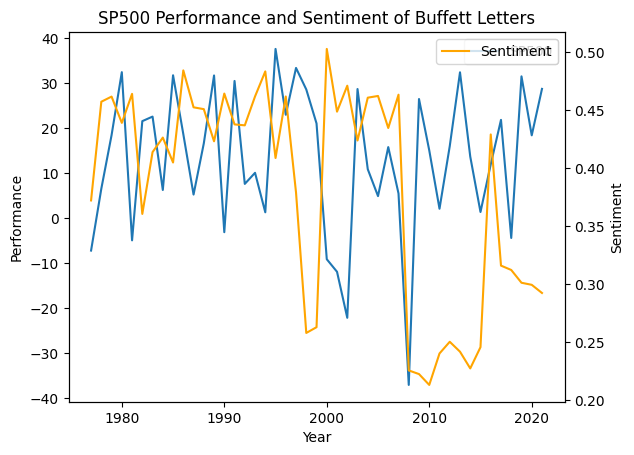

In [75]:
# Predict sentiment of each letter
sentiments = []
for letter in letters:
    preds = model.predict(letter, verbose=0)
    sentiments.append(preds.mean())

# Add sentiments to df
df['Sentiment'] = sentiments

# Plot SP500 performance and sentiment
fig, ax = plt.subplots()
ax.plot(df['Year'], df['SP500'], label='SP500')
ax.set_title('SP500 Performance and Sentiment of Buffett Letters')
ax.set_xlabel('Year')
ax.set_ylabel('Performance')
ax.legend()
ax2 = ax.twinx()
ax2.plot(df['Year'], df['Sentiment'], color='orange', label='Sentiment')
ax2.set_ylabel('Sentiment')
ax2.legend()

Very basic network (one embedding layer, one pooling layer, one hidden layer) gives average sentiment a little over 50% for all sentences in each letter. The model was trained on the imdb dataset where a one indicates a positive review and a zero indicates a negative review.